# Consigna del desafío 1

**1**. Vectorizar documentos. Tomar 5 documentos al azar y medir similaridad con el resto de los documentos.
Estudiar los 5 documentos más similares de cada uno analizar si tiene sentido
la similaridad según el contenido del texto y la etiqueta de clasificación.

**2**. Entrenar modelos de clasificación Naïve Bayes para maximizar el desempeño de clasificación
(f1-score macro) en el conjunto de datos de test. Considerar cambiar parámteros
de instanciación del vectorizador y los modelos y probar modelos de Naïve Bayes Multinomial
y ComplementNB.

**3**. Transponer la matriz documento-término. De esa manera se obtiene una matriz
término-documento que puede ser interpretada como una colección de vectorización de palabras.
Estudiar ahora similaridad entre palabras tomando 5 palabras y estudiando sus 5 más similares.


In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict

from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score

import nltk
from nltk.corpus import stopwords


### Resolucion de la consigna 1

In [2]:
# cargamos los datos (ya separados de forma predeterminada en train y test)
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

In [3]:
# Creo un objeto TfidfVectorizer
tfidfvect= TfidfVectorizer()

In [4]:
# con la interfaz habitual de sklearn podemos fitear el vectorizador
# (obtener el vocabulario y calcular el vector IDF)
# y transformar directamente los datos
X_train = tfidfvect.fit_transform(newsgroups_train.data)
# `X_train` la podemos denominar como la matriz documento-término

In [5]:
# recordar que las vectorizaciones por conteos son esparsas
# por ello sklearn convenientemente devuelve los vectores de documentos
# como matrices esparsas
print(type(X_train))
print(f'shape: {X_train.shape}')
print(f'cantidad de documentos: {X_train.shape[0]}')
print(f'tamaño del vocabulario (dimensionalidad de los vectores): {X_train.shape[1]}')

<class 'scipy.sparse._csr.csr_matrix'>
shape: (11314, 101631)
cantidad de documentos: 11314
tamaño del vocabulario (dimensionalidad de los vectores): 101631


In [6]:
# es muy útil tener el diccionario opuesto que va de índices a términos
idx2word = {v: k for k,v in tfidfvect.vocabulary_.items()}

In [7]:
# Tomar 5 documentos al azar
indices_aleatorios = np.random.choice(X_train.shape[0], 5, replace=False)
documentos_aleatorios = X_train[indices_aleatorios]

In [8]:
indices_aleatorios

array([9932, 6192, 6698,  175, 9399])

In [9]:
# Calcular la similitud del coseno con el resto de los documentos
similitud_cos = cosine_similarity(documentos_aleatorios, X_train)
similitud_cos

array([[0.10299124, 0.03984352, 0.10936748, ..., 0.06931644, 0.0362655 ,
        0.01005914],
       [0.0560801 , 0.05256229, 0.08598283, ..., 0.05755079, 0.03408434,
        0.02150173],
       [0.04426323, 0.04292127, 0.07709714, ..., 0.05035234, 0.06263551,
        0.00767201],
       [0.04638048, 0.03783243, 0.08778188, ..., 0.04997892, 0.05935829,
        0.0194923 ],
       [0.09486411, 0.04482149, 0.15469914, ..., 0.06272897, 0.06639768,
        0.01220654]])

In [10]:
pares_docus = []

# Estudiar los 5 documentos más similares de cada uno
for i in range(len(indices_aleatorios)):
    idx = indices_aleatorios[i]
    print(f"Documento {idx}:")
    for j, idx_similar in enumerate(np.argsort(similitud_cos[i])[::-1][1:6]):  # Excluir el documento en sí mismo
        pares_docus.append((idx, idx_similar,similitud_cos[i][idx_similar]))

        # Imprimir los resultados
        print(f"Similar al documento {idx_similar}, con similitud_coseno: {similitud_cos[i][idx_similar]}")

# Guardar las pares i y j
print("Pares guardados:")
print(pares_docus)


Documento 9932:
Similar al documento 8193, con similitud_coseno: 0.30004731664184686
Similar al documento 734, con similitud_coseno: 0.2480122005709084
Similar al documento 7698, con similitud_coseno: 0.2418917996673219
Similar al documento 4362, con similitud_coseno: 0.23359515843818765
Similar al documento 2772, con similitud_coseno: 0.22673877857420655
Documento 6192:
Similar al documento 10077, con similitud_coseno: 0.33665077027032453
Similar al documento 10344, con similitud_coseno: 0.20050173969699817
Similar al documento 4271, con similitud_coseno: 0.19388261422866102
Similar al documento 3746, con similitud_coseno: 0.19267973309298844
Similar al documento 6369, con similitud_coseno: 0.1913684003202642
Documento 6698:
Similar al documento 9188, con similitud_coseno: 0.26470256891801247
Similar al documento 10669, con similitud_coseno: 0.21440147287383343
Similar al documento 3263, con similitud_coseno: 0.20962595268770792
Similar al documento 2913, con similitud_coseno: 0.20849

In [11]:
## analizo coicidencia de targets para cada documento elegido aleatoriamente y los 5 más similares.

# Creo un diccionario para almacenar el recuento de coincidencias por grupo de idx
coincidencias_por_grupo = defaultdict(int)

# Itero sobre los pares idx e idx_similar en pares_docus
for idx, idx_similar, _ in pares_docus:
    # Objetivos correspondientes a idx e idx_similar
    target_idx = newsgroups_train.target[idx]
    target_idx_similar = newsgroups_train.target[idx_similar]
    
    # Recuento si los objetivos son iguales
    if target_idx == target_idx_similar:
        coincidencias_por_grupo[idx] += 1

# Imprimir el recuento de coincidencias por grupo de idx
print("Coicidencia de targets para cada documento elegido aleatoriamente y sus 5 más similares")
for idx, coincidencias in coincidencias_por_grupo.items():
    print(f"Documento con idx {idx}: {coincidencias} coincidencias")


Coicidencia de targets para cada documento elegido aleatoriamente y sus 5 más similares
Documento con idx 9932: 4 coincidencias
Documento con idx 6192: 3 coincidencias
Documento con idx 6698: 5 coincidencias
Documento con idx 175: 4 coincidencias
Documento con idx 9399: 5 coincidencias


Se observa que la predicción del target de cada documento no siempre no siempre es la correcta.

In [12]:
print("Comparación de data para cada documento elegido aleatoriamente y sus 5 más similares:")
print("")
for idx, idx_similar, _ in pares_docus:
    # Imprimir data correspondiente a idx
    print(f"Documento con idx {idx}:")
    print(newsgroups_train.data[idx])
    print()
    
    # Imprimir data correspondiente a idx_similar
    print(f"Documento similar: idx {idx_similar}")
    print(newsgroups_train.data[idx_similar])
    print()


Comparación de data para cada documento elegido aleatoriamente y sus 5 más similares:

Documento con idx 9932:




J.N. Darby was one of the founders of the "Plymouth Brethren" and an
early supporter of dispensationalism.  F.F. Bruce highly approved
of his translation.  He also translated the Bible into several other
languages.


This was from the same fellow who did Young's Concordance, which was
a standard reference work, similar to Strong's concordance.


I believe that these just follow standard reference works.


Some are by Larry Pierce ("Brethren"), some are by Baptists, and I
think that Thompson (of chain reference fame) was Presbyterian)


Another standard reference work that has been around for decades.
A new version was just released and is available through Christian
Book Distributers.


C.I. Scofield was the creator of the Scofield Reference Bible.  For many
people (but not me), this is THE STUDY BIBLE.  The notes are strongly
dispensational.


These are probably the most 

### Resolucion de la consigna 2

In [13]:
# Descargar las stopwords (si no las tienes ya descargadas)
nltk.download('stopwords')

# Obtener la lista de stopwords en el idioma deseado (por ejemplo, inglés)
stopwords = set(stopwords.words('english'))
stopwords = list(stopwords) #convierto a listas


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alede\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Defino los modelos y vectorizadores
models = {
    "MultinomialNB": MultinomialNB(),
    "ComplementNB": ComplementNB()
}

vectorizers = {
    "TF-IDF": TfidfVectorizer(),
    "CountVectorizer": CountVectorizer(),
    "TF-IDF-stopwords": TfidfVectorizer(stop_words=stopwords),
    "CountVectorizer-stopwords": CountVectorizer(stop_words=stopwords)
}

# Bucle sobre combinaciones de modelo y vectorizador
for model_name, model in models.items():
    for vectorizer_name, vectorizer in vectorizers.items():
        # Creo el pipeline
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', model)
        ])
        
        # Entrenamiento del modelo
        pipeline.fit(newsgroups_train.data, newsgroups_train.target)
        
        # Prediccion en el conjunto de test
        y_pred = pipeline.predict(newsgroups_test.data)
        
        # Resultado
        print(f"Modelo: {model_name}, Vectorizador: {vectorizer_name}")
        print(classification_report(newsgroups_test.target, y_pred))


Modelo: MultinomialNB, Vectorizador: TF-IDF
              precision    recall  f1-score   support

           0       0.81      0.07      0.13       319
           1       0.72      0.62      0.67       389
           2       0.70      0.50      0.59       394
           3       0.55      0.75      0.64       392
           4       0.81      0.61      0.69       385
           5       0.83      0.74      0.78       395
           6       0.86      0.69      0.77       390
           7       0.82      0.68      0.74       396
           8       0.89      0.63      0.73       398
           9       0.95      0.69      0.80       397
          10       0.59      0.90      0.71       399
          11       0.47      0.80      0.59       396
          12       0.77      0.43      0.55       393
          13       0.86      0.63      0.73       396
          14       0.84      0.63      0.72       394
          15       0.22      0.95      0.36       398
          16       0.59      0.59    

La mayoria de las categorías tienen un mejor f1-score con el modelo ComplementNB y vectorizador TF-IDF (tengo stop_words en su parámetros o no).

Existen categorias cuyo f1-score es bajo en todos los casos.

En general, el modelo MultinomialNB tiene un mal desempeño cualquiera sea el vectorizador utilizado.


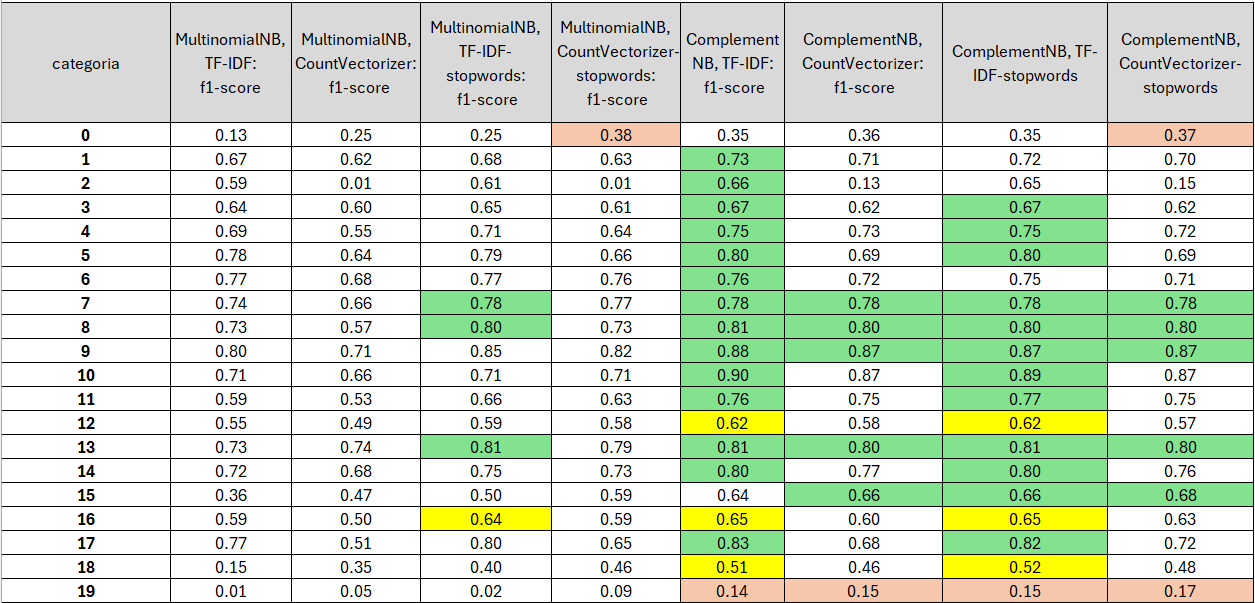

### Resolucion de la consigna 3

In [18]:
# Transponer la matriz documento-término. De esa manera se obtiene una matriz 
# término-documento que puede ser interpretada como una colección de vectorización de palabras.

X_train_transposed = X_train.transpose()

# Obtener el vocabulario de términos
vocabulario = np.array(tfidfvect.get_feature_names_out())

# Crear el diccionario opuesto que mapea índices a términos
idx2word = {v: k for k, v in tfidfvect.vocabulary_.items()}


In [19]:
vocabulario

array(['00', '000', '0000', ..., 'zzzzzzt', '³ation', 'ýé'], dtype=object)

In [20]:
# Definir las palabras para estudiar su similitud
palabras_a_estudiar = ['science', 'space', 'computer', 'car', 'medicine']

for palabra in palabras_a_estudiar:
    # Obtener el índice de la palabra en el vocabulario
    indice_palabra = np.where(vocabulario == palabra)[0][0] ################## ver
    
    # Calcular la similitud del coseno entre la palabra y todas las demás palabras
    similitudes = cosine_similarity(X_train_transposed[indice_palabra], X_train_transposed)
    
    # Obtener los índices de las palabras más similares (excluyendo la propia palabra)
    indices_similares = similitudes.argsort()[0][-6:-1][::-1]
    
    # Imprimir las palabras más similares
    print(f"Palabra: {palabra}")
    print("Palabras más similares:")
    for indice in indices_similares:
        # Usar el diccionario idx2word para obtener el término correspondiente al índice
        print(idx2word[indice])
    print()

Palabra: science
Palabras más similares:
behaviorists
cognitivists
scientific
empirical
sects

Palabra: space
Palabras más similares:
nasa
seds
shuttle
enfant
seti

Palabra: computer
Palabras más similares:
decwriter
harkens
deluged
shopper
the

Palabra: car
Palabras más similares:
cars
criterium
civic
owner
dealer

Palabra: medicine
Palabras más similares:
strengthens
dislikes
nearer
foremost
neurodermitis



**Traducción de las palabras al español**:

* Ciencia:

behaviorists -> conductistas

cognitivists -> cognitivistas

scientific -> científico

empirical -> empírico

sects -> sectas

* Espacio:

nasa -> NASA

seds -> SEDS (Students for the Exploration and Development of Space)

shuttle -> transbordador

enfant -> infantil

seti -> SETI (Search for Extraterrestrial Intelligence)

* Computadora:

decwriter -> Decwriter 

harkens -> resuena

deluged -> inundado

shopper -> comprador

the -> el

* Automóvil:

cars -> automóviles

criterium -> criterio

civic -> cívico

owner -> dueño

dealer -> distribuidor

* Medicina:

strengthens -> fortalece

dislikes -> disgustos

nearer -> más cercano/a

foremost -> principal

neurodermitis -> neurodermatitis

**nálisis de resultados**:

* Science:

Las palabras más similares incluyen "behaviorists", "cognitivists", "scientific", "empirical" y "sects". Estas palabras están relacionadas con diferentes aspectos del campo científico y académico


* Space:

Las palabras más similares incluyen "nasa", "seds", "shuttle", "enfant" y "seti". Estas palabras están relacionadas con el espacio y la exploración espacial.

* Computer:

Las palabras más similares incluyen "decwriter", "harkens", "deluged", "shopper" y "the". Sin embargo, algunas de estas palabras parecen no estar relacionadas directamente con la informática o la tecnología. Puede ser que estas palabras tengan diferentes significados dependiendo del contexto o que justamente la similiradidad esté en el contexto en que apareció la palabra.

* Car:

Las palabras más similares incluyen "cars", "criterium", "civic", "owner" y "dealer". Estas palabras están relacionadas con diferentes aspectos del automóvil, como tipos de automóviles, eventos de automovilismo y roles relacionados con la propiedad y la venta de automóviles.

*  Medicine:

Las palabras más similares incluyen "strengthens", "dislikes", "nearer", "foremost" y "neurodermitis". La presencia de palabras como "dislikes" y "nearer" no tienen relacion con Medicine, es posible que la a similiradidad esté en el contexto en que apareció la palabra.